Exercises

1) Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

2) Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

My machine couldn't cope with the whole dataset using neighbors algorithm - so I had to take only a small part of the dataset (the part that supposed to be a test set). The reducing training dataset of course had a negative effect on learning

In [2]:
X, y = fetch_openml('mnist_784', return_X_y=True)
X, y = X[60000:], y[60000:]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [ ]:
np.unique(y_train, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([735, 851, 774, 757, 736, 669, 719, 771, 731, 757]))

In [ ]:
np.unique(y_test, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([245, 284, 258, 253, 246, 223, 239, 257, 243, 252]))

In [ ]:
clf = KNeighborsClassifier(3)

In [ ]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
cv_std = cross_val_score(clf, X_train_std, y_train, scoring='accuracy', cv=3)

mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
cv_mm = cross_val_score(clf, X_train_mm, y_train, scoring='accuracy', cv=3)

print(cv_std, cv_mm, sep='\n')

[0.8964 0.9076 0.9032]
[0.9428 0.9372 0.9436]


In [ ]:
knn = Pipeline([('scaling', StandardScaler()),
                ('clf', KNeighborsClassifier())])

grid = GridSearchCV(knn, {'scaling': [MinMaxScaler(), StandardScaler()], 
                          'clf__n_neighbors': [4, 5, 6], 
                          'clf__weights': ['uniform', 'distance']}, 
                    cv=3, scoring='accuracy')

grid.fit(X_train, y_train)

cvres = grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9354666666666667 {'clf__n_neighbors': 4, 'clf__weights': 'uniform', 'scaling': MinMaxScaler(copy=True, feature_range=(0, 1))}
0.8989333333333333 {'clf__n_neighbors': 4, 'clf__weights': 'uniform', 'scaling': StandardScaler(copy=True, with_mean=True, with_std=True)}
0.9449333333333333 {'clf__n_neighbors': 4, 'clf__weights': 'distance', 'scaling': MinMaxScaler(copy=True, feature_range=(0, 1))}
0.9091999999999999 {'clf__n_neighbors': 4, 'clf__weights': 'distance', 'scaling': StandardScaler(copy=True, with_mean=True, with_std=True)}
0.9381333333333334 {'clf__n_neighbors': 5, 'clf__weights': 'uniform', 'scaling': MinMaxScaler(copy=True, feature_range=(0, 1))}
0.8999999999999999 {'clf__n_neighbors': 5, 'clf__weights': 'uniform', 'scaling': StandardScaler(copy=True, with_mean=True, with_std=True)}
0.9397333333333334 {'clf__n_neighbors': 5, 'clf__weights': 'distance', 'scaling': MinMaxScaler(copy=True, feature_range=(0, 1))}
0.9053333333333334 {'clf__n_neighbors': 5, 'clf__weights': 'distance

In [ ]:
grid_mm = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': list(range(8,21,3)),
                                                'weights': ['uniform', 'distance']}, 
                        cv=3, scoring='accuracy')

grid_mm.fit(X_train_mm, y_train)

cvres_mm = grid_mm.cv_results_
for mean_score, params in zip(cvres_mm["mean_test_score"], cvres_mm["params"]):
    print(mean_score, params)

0.9308000000000001 {'n_neighbors': 8, 'weights': 'uniform'}
0.9385333333333333 {'n_neighbors': 8, 'weights': 'distance'}
0.9283999999999999 {'n_neighbors': 11, 'weights': 'uniform'}
0.9338666666666665 {'n_neighbors': 11, 'weights': 'distance'}
0.9254666666666665 {'n_neighbors': 14, 'weights': 'uniform'}
0.9308 {'n_neighbors': 14, 'weights': 'distance'}
0.9210666666666666 {'n_neighbors': 17, 'weights': 'uniform'}
0.9261333333333334 {'n_neighbors': 17, 'weights': 'distance'}
0.9196 {'n_neighbors': 20, 'weights': 'uniform'}
0.9229333333333334 {'n_neighbors': 20, 'weights': 'distance'}


In [ ]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=4, p=2,
                                      weights='distance'))],
         verbose=False)

In [ ]:
grid_best = grid.best_estimator_.fit(X_train, y_train)
grid_best.score(X_test, y_test)

0.9552

In [4]:
from scipy.ndimage.interpolation import shift
from sklearn.base import BaseEstimator, TransformerMixin

class ImageShift(BaseEstimator, TransformerMixin):
    def __init__(self, pixh, pixv): 
        self.pixh = pixh
        self.pixv = pixv
    def fit(self, X, y):
        return self  
    def transform(self, X, y):
        temp = np.empty((1, 784), 'int')
        
        for i in range(len(X)):
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [self.pixv, 0]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [-self.pixv, 0]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [0, self.pixh]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [0, -self.pixh]).reshape(1, 784), axis=0)
        
        X = np.insert(temp[1:], range(0, len(temp[1:]), len(temp[1:]) // len(X)), X, 0)
        y_temp = np.insert(y, range(len(y)), y, 0)
        y_temp = np.insert(y_temp, range(len(y_temp)), y_temp, 0)
        y = np.insert(y_temp, range(0, len(y_temp), len(y_temp) // len(y)), y, 0)

        return X, y




In [ ]:
# Doesn't combine fit_transform - wrote this function in my class specifically lower

img_shifter = ImageShift(1, 1)
img_shifter.fit(X_train, y_train)

X_train_sh, y_train_sh = img_shifter.transform(X_train, y_train)

In [5]:
img = ImageShift(1, 1).fit(X_train[:5], y_train[:5])
X_train_sh, y_train_sh = img.transform(X_train[:5], y_train[:5])

In [ ]:
grid_best_sh = grid.best_estimator_.fit(X_train_sh, y_train_sh)
grid_best_sh.score(X_test, y_test)

0.964

Implementing the image shift results in "combinatorial explosion", so I had to use it only on very small number of instances just for learning purposes

In [8]:
len(X_train_sh), len(y_train_sh)

(25, 25)

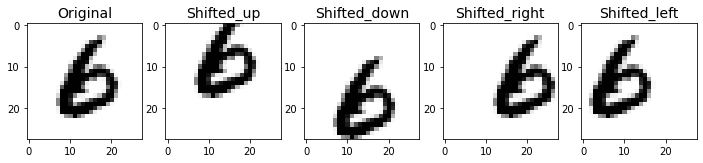

In [34]:
shifted_image = ImageShift(5, -5).fit(X_train[:5], y_train[:5])
X_train_sh, y_train_sh = shifted_image.transform(X_train[:5], y_train[:5])

plt.figure(figsize=(12,3))
plt.subplot(151)
plt.title("Original", fontsize=14)
plt.imshow(X_train_sh[0].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(152)
plt.title("Shifted_up", fontsize=14)
plt.imshow(X_train_sh[1].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(153)
plt.title("Shifted_down", fontsize=14)
plt.imshow(X_train_sh[2].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(154)
plt.title("Shifted_right", fontsize=14)
plt.imshow(X_train_sh[3].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(155)
plt.title("Shifted_left", fontsize=14)
plt.imshow(X_train_sh[4].reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.show()

In [9]:
from scipy.ndimage.interpolation import shift
from sklearn.base import BaseEstimator, TransformerMixin

class ImageShift(BaseEstimator, TransformerMixin):
    def __init__(self, pixh=1, pixv=1): 
        self.pixh = pixh
        self.pixv = pixv
    def fit(self, X, y):
        return self  
    def transform(self, X, y):
        temp = np.empty((1, 784), 'int')
        
        for i in range(len(X)):
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [self.pixv, 0]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [-self.pixv, 0]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [0, self.pixh]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [0, -self.pixh]).reshape(1, 784), axis=0)
        
        X = np.insert(temp[1:], range(0, len(temp[1:]), len(temp[1:]) // len(X)), X, 0)
        y_temp = np.insert(y, range(len(y)), y, 0)
        y_temp = np.insert(y_temp, range(len(y_temp)), y_temp, 0)
        y = np.insert(y_temp, range(0, len(y_temp), len(y_temp) // len(y)), y, 0)

        return X, y

    def fit_transform(self, X, y):
        temp = np.empty((1, 784), 'int')
        
        for i in range(len(X)):
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [self.pixv, 0]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [-self.pixv, 0]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [0, self.pixh]).reshape(1, 784), axis=0)
            temp = np.append(temp, shift(X[i].reshape(28, 28), 
                                [0, -self.pixh]).reshape(1, 784), axis=0)
        
        X = np.insert(temp[1:], range(0, len(temp[1:]), len(temp[1:]) // len(X)), X, 0)
        y_temp = np.insert(y, range(len(y)), y, 0)
        y_temp = np.insert(y_temp, range(len(y_temp)), y_temp, 0)
        y = np.insert(y_temp, range(0, len(y_temp), len(y_temp) // len(y)), y, 0)

        return X, y

In [ ]:
# Straight gridsearch doesn't work with my shifting class 
# (I guess cannot process the transformed y output)
# Wrote my own grid function lower

pipe_shift = Pipeline([('img_shifter', ImageShift()), 
                       ('scaling', StandardScaler()),
                       ('clf', KNeighborsClassifier())])

param = {'img_shifter__pixh': [1, 2, 3],
         'img_shifter__pixv': [1, 2, 3],
         'scaling': [MinMaxScaler(), StandardScaler()], 
         'clf__n_neighbors': [4, 6, 8], 
         'clf__weights': ['uniform', 'distance']}

grid_shift = GridSearchCV(pipe_shift, param, cv=3, scoring='accuracy')

grid_shift.fit(X_train[:50], y_train[:50])

cvres = grid_shift.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

In [ ]:
def grid_shift(X, y):
  acc = 0

  pipe = Pipeline([('scaling', StandardScaler()),
                   ('clf', KNeighborsClassifier())])
  
  param = {'scaling': [MinMaxScaler(), StandardScaler()], 
         'clf__n_neighbors': [4, 6, 8], 
         'clf__weights': ['uniform', 'distance']}

  grid_search = GridSearchCV(pipe, param, cv=3, scoring='accuracy')
  
  for i in range(1,4):
    for j in range(1,4):
      X_sh, y_sh = ImageShift(i, j).fit_transform(X, y)
      grid_search.fit(X_sh, y_sh)
      if grid_search.best_score_ > acc:
        acc = grid_search.best_score_
        clf = grid_search.best_estimator_
        ph, pv = i, j

  return clf, ph, pv, acc


In [9]:
grid_shift(X_train[:100], y_train[:100])

(Pipeline(steps=[('scaling', MinMaxScaler()),
                 ('clf',
                  KNeighborsClassifier(n_jobs=-1, n_neighbors=4,
                                       weights='distance'))]),
 1,
 1,
 0.6719693143832816)